# Gets summary statistics of all the results gotten so far

- Mean target value selected
- Min target value selected
- Time until minimum selected

In [1]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt

from result_utils import all_means, box_plots_mean, all_best, all_uncertainties, iterations_to_min, plot_everything

# Best Y

[-1.78897399 -1.84741207 -1.87221799 -1.88212477 -1.88275002 -1.88997868
 -1.89026919 -1.89473413 -1.89473413 -1.89800807 -1.89884634 -1.91108911
 -1.91525763 -1.91672895 -1.91672895 -1.91672895 -1.91744334 -1.92357364
 -1.92357364 -1.92357364 -1.92896591 -1.92896591 -1.93082886 -1.93082886
 -1.93357785 -1.93422058 -1.93648014 -1.93648014 -1.93720295 -1.93720295
 -1.93782589 -1.94042711 -1.94042711 -1.94042711 -1.94042711 -1.94042711
 -1.94042711 -1.94042711 -1.94042711 -1.94042711 -1.94042711 -1.94042711
 -1.94042711 -1.94042711 -1.94042711 -1.94042711 -1.96148147 -1.96148147
 -1.96358797 -1.96358797] [0.08050974 0.15537499 0.13227152 0.12669729 0.12624974 0.12826201
 0.12816637 0.12658983 0.12658983 0.12537627 0.12503147 0.12643939
 0.12574242 0.12504698 0.12504698 0.12504698 0.12476425 0.11673228
 0.11673228 0.11673228 0.11368118 0.11368118 0.11269168 0.11269168
 0.11190144 0.11098242 0.10991249 0.10991249 0.10978378 0.10978378
 0.10970713 0.10804268 0.10804268 0.10804268 0.10804268

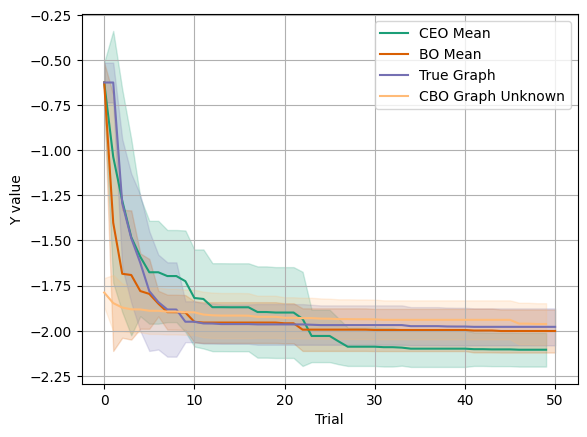

In [2]:
base_path = "ToyGraph"
plot_everything(base_path=base_path, experiment="Best_Y", num_cbo_graphs=5, graph_idxs=[0], n_obs=200)


[13.62016741 13.52515501 13.47342796 13.45249026 13.37887685 13.37887685
 13.36923223 13.35796275 13.28982977 13.28982977 13.24398621 13.21215375
 13.17830931 13.17564651 13.17290973 13.17147508 13.16911937 13.16479311
 13.16479311 13.16479311 13.16017217 13.16017217 13.16017217 13.16017217
 13.1600441  13.1600441  13.1600441  13.1600441  13.15890219 13.15890219
 13.15890219 13.15890219 13.15769905 13.15489702 13.15412533 13.15412533
 13.15412533 13.15412533 13.15412533 13.15412533 13.15412533 13.15314049
 13.15314049 13.15222771 13.15222771 13.15222771 13.15222771 13.15219192
 13.15219192 13.15151399] [0.23065455 0.20333068 0.19338338 0.19617263 0.21835494 0.21835494
 0.20832878 0.19865921 0.16780546 0.16780546 0.14862286 0.12550754
 0.08561911 0.08374604 0.08144109 0.08300853 0.08598856 0.09107332
 0.09107332 0.09107332 0.09622038 0.09622038 0.09622038 0.09622038
 0.09637497 0.09637497 0.09637497 0.09637497 0.09557762 0.09557762
 0.09557762 0.09557762 0.09703395 0.09275501 0.09223431

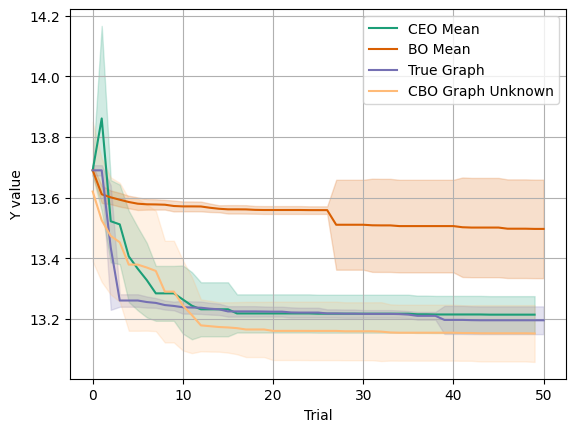

In [3]:
base_path = "Graph6"
plot_everything(base_path=base_path, experiment="Best_Y", num_cbo_graphs=5, graph_idxs=[0], n_obs=200)

[ 0.05850895 -0.65960985 -0.69374749 -0.80972086 -0.80972086 -0.93257972
 -1.00371426 -1.00700569 -1.01652554 -1.01652554 -1.03818827 -1.06592391
 -1.06592391 -1.06592391 -1.06592391 -1.06592391 -1.07756186 -1.08112985
 -1.08169544 -1.08455106 -1.08455106 -1.08860033 -1.08860033 -1.09377733
 -1.1882716  -1.1882716  -1.1882716  -1.1882716  -1.1882716  -1.2897754
 -1.2897754  -1.2897754  -1.2897754  -1.2897754  -1.2897754  -1.2897754
 -1.2897754  -1.30247298 -1.30447459 -1.30978249 -1.31418171 -1.31418171
 -1.31418171 -1.31645706 -1.31645706 -1.31809636 -1.31809636 -1.31809636
 -1.31809636 -1.31809636] [0.9961301  0.67991449 0.61724984 0.62046384 0.62046384 0.46259333
 0.44012995 0.43830516 0.43441324 0.43441324 0.44553779 0.46430147
 0.46430147 0.46430147 0.46430147 0.46430147 0.45054187 0.45388778
 0.45316006 0.45583137 0.45583137 0.45898462 0.45898462 0.46283615
 0.42256954 0.42256954 0.42256954 0.42256954 0.42256954 0.38484099
 0.38484099 0.38484099 0.38484099 0.38484099 0.38484099 0

/Users/jeandurand/Documents/Masters Thesis/causal_bayes_opt/ceo_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jeandurand/Documents/Masters Thesis/causal_bayes_opt/ceo_venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeandurand/Documents/Masters Thesis/causal_bayes_opt/ceo_venv/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeandurand/Documents/Masters Thesis/causal_bayes_opt/ceo_venv/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeandurand/Documents/Masters Thesis/causal_bayes_opt/ceo_venv/lib/python3.10/site-pac

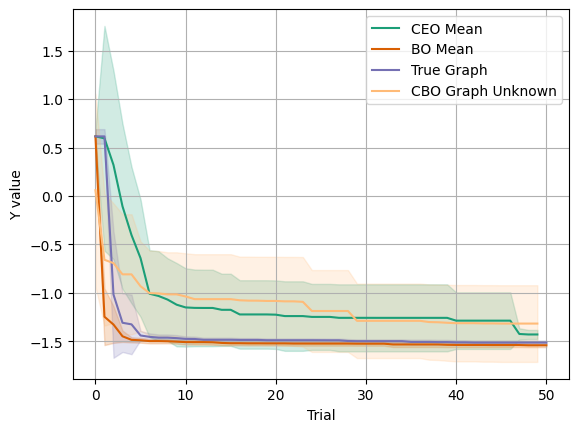

In [4]:
base_path = "Graph5"
plot_everything(base_path=base_path, experiment="Best_Y", num_cbo_graphs=5, graph_idxs=[0], n_obs=200, plot_ceo=True)

# Getting the statistics for Graph 5

In [5]:
base_path = "Graph5"
# plot_everything(base_path=base_path, experiment="Best_Y", n_obs=10, num_cbo_graphs=7,save_file=False, plot_ceo=True, graph_idxs = [0, 4, 6])
mean_results = all_means(base_path=base_path, num_cbo_graphs=4, n_obs=200, has_cbo_unknown=False)
print(mean_results)

{'ceo': {'mean': 0.4626989493224457, 'std': 0.8746378830478275}, 'bo': {'mean': -1.2297971684099853, 'std': 0.5149836900244269}, 'cbo_0': {'mean': -1.3968123459532167, 'std': 0.19015763730464197}, 'cbo_1': {'mean': -1.4012846800854402, 'std': 0.16009135699055094}, 'cbo_2': {'mean': -1.3289204017175387, 'std': 0.3451265914621636}, 'cbo_3': {'mean': -1.292877136210958, 'std': 0.3592047811909343}}


In [6]:
base_path = "Graph5"
# plot_everything(base_path=base_path, experiment="Best_Y", n_obs=10, num_cbo_graphs=7,save_file=False, plot_ceo=True, graph_idxs = [0, 4, 6])
mean_results = all_best(base_path=base_path, num_cbo_graphs=4, n_obs=200, has_cbo_unknown=False)
print(mean_results)

{'ceo': {'mean': -1.4306525705472874, 'std': 0.04698376549770791}, 'bo': {'mean': -1.5424044583452043, 'std': 0.019406563741089292}, 'cbo_0': {'mean': -1.5144256444183344, 'std': 0.02039856680590944}, 'cbo_1': {'mean': -1.5151522475070398, 'std': 0.01877991313690364}, 'cbo_2': {'mean': -1.5095983964222444, 'std': 0.01989167516329695}, 'cbo_3': {'mean': -1.496050263195043, 'std': 0.02274831057939501}}


# Per trial Y

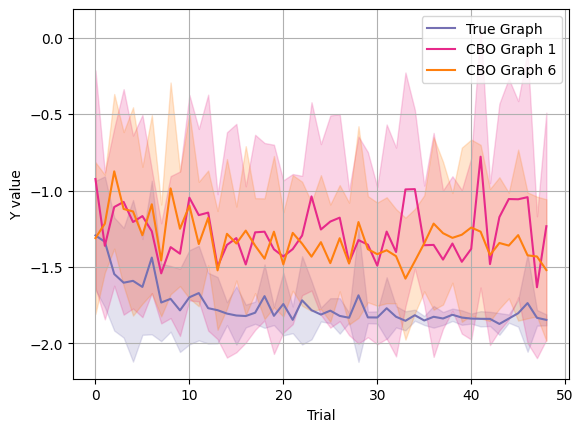

In [8]:
base_path = "ToyGraph"
plot_everything(base_path=base_path, experiment="Per_trial_Y", num_cbo_graphs=7, n_obs=200, graph_idxs=[0, 1, 6], plot_ceo=False, plot_bo=False, plot_cbo_unknown=False, save_file=True)

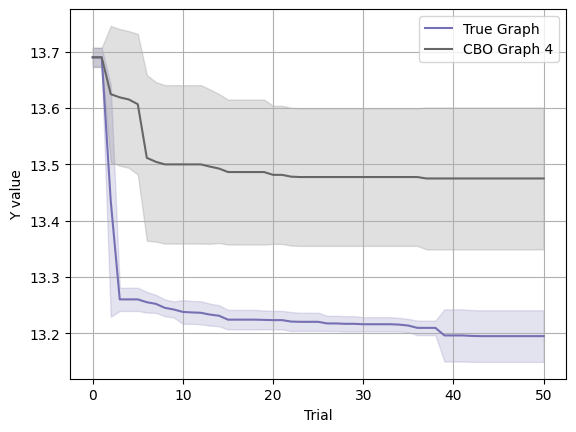

In [10]:
base_path = "Graph6"
plot_everything(base_path=base_path, experiment="Best_Y", num_cbo_graphs=5, graph_idxs=[0, 4], n_obs=200, plot_ceo=False, plot_bo=False, plot_cbo_unknown=False, save_file=True)

[ 0.05850895 -0.45186756 -0.07566743 -0.30474286  0.04356271 -0.38082586
 -0.01848389 -0.40617249 -0.4516257  -0.06961135 -0.25720086 -0.69522857
 -0.42123229  0.00193673 -0.25434822 -0.12600254 -0.02877953 -0.59518973
 -0.29209045 -0.57403937 -0.34829496 -0.29675116 -0.11595342  0.0084669
 -0.04125319 -0.35242719  0.12090061 -0.46639108 -0.18776662 -0.36399651
 -0.46512255 -0.08789691 -0.34033644 -0.3359399  -0.48081013 -0.19685525
 -0.25296878 -0.70937517 -0.70263652 -0.92297736 -0.55953293 -0.84330958
 -0.54332297 -0.58750077 -0.40400555 -0.48994811  0.12054695 -0.19289475
  0.44978399  0.41648532] [0.9961301  0.66917097 0.76716505 0.8328773  0.70564479 0.47811373
 0.66791357 0.6327763  0.56529629 0.48277597 0.75056593 0.65968023
 0.66257836 0.72492664 0.6478427  0.70802438 0.55103853 0.62942599
 0.63935394 0.52790169 0.50235905 0.82350714 0.77656324 0.80929045
 0.72416349 0.77858353 0.82832069 0.54920918 0.64251227 1.01639678
 0.57525286 1.00410832 0.69952495 0.86120863 0.88687589 

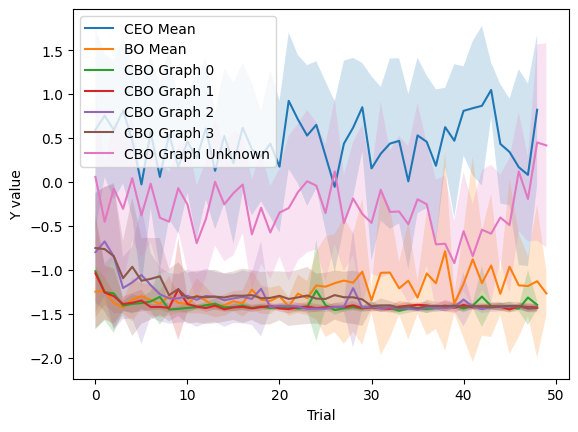

In [11]:
base_path = "Graph5"
plot_everything(base_path=base_path, experiment="Per_trial_Y", num_cbo_graphs=4, n_obs=200, plot_ceo=True)

{'ceo': {'mean': -2.1061331833974073, 'std': 0.09354404575537081}, 'bo': {'mean': -2.0023437411387808, 'std': 0.11948311572972448}, 'cbo_0': {'mean': -1.9792135517303955, 'std': 0.10251784413521531}, 'cbo_1': {'mean': -2.1211238017549117, 'std': 0.10276845617409738}, 'cbo_2': {'mean': -1.9795963550170292, 'std': 0.11012699313567903}, 'cbo_3': {'mean': -1.9840844868702745, 'std': 0.11340955195490156}, 'cbo_4': {'mean': -1.9862983772201495, 'std': 0.11868158023607887}, 'cbo_5': {'mean': -1.9745039504238509, 'std': 0.09424626357011888}, 'cbo_6': {'mean': -1.9406322419320012, 'std': 0.26461045367880887}}


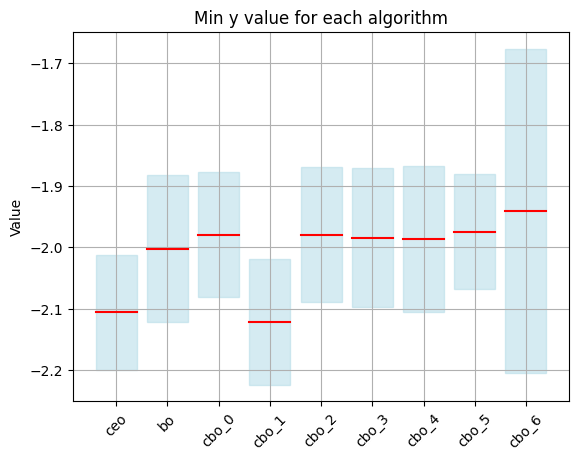

In [3]:
min_results = all_best(base_path=base_path, num_cbo_graphs=7, n_obs=200)
print(min_results)
box_plots_mean(min_results, experiment="Min")

{'ceo': {'mean': 20.8, 'std': 15.860643114325473}, 'bo': {'mean': 30.1, 'std': 14.446106741956463}, 'cbo_0': {'mean': 25.1, 'std': 13.456968455042167}, 'cbo_1': {'mean': 31.6, 'std': 12.784365451597509}, 'cbo_2': {'mean': 25.1, 'std': 13.277424449041312}, 'cbo_3': {'mean': 26.4, 'std': 13.200000000000001}, 'cbo_4': {'mean': 28.3, 'std': 10.564563407921787}, 'cbo_5': {'mean': 21.4, 'std': 14.037093716293269}, 'cbo_6': {'mean': 19.5, 'std': 13.070960178961606}}


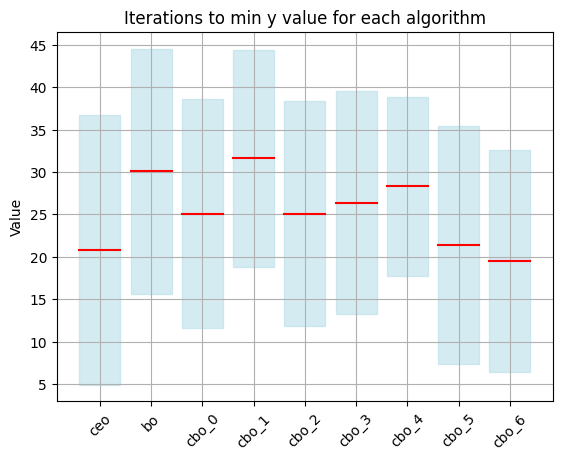

In [4]:
argmin_results = iterations_to_min(base_path=base_path, num_cbo_graphs=7)
print(argmin_results)
box_plots_mean(argmin_results, experiment="Iterations to min")

{'bo': {'mean': 2.607043461259105, 'std': 0.22989255264803574}, 'cbo_0': {'mean': 2.3768196327308884, 'std': 0.2662949513166599}, 'cbo_1': {'mean': 2.4884037663794154, 'std': 0.21950324642683242}, 'cbo_2': {'mean': 3.720709851362166, 'std': 0.313143368593057}, 'cbo_3': {'mean': 1.828487996282154, 'std': 0.23652972375615416}, 'cbo_4': {'mean': 2.607043461259105, 'std': 0.22989255264803715}, 'cbo_5': {'mean': 3.1723782149134307, 'std': 0.29895428942952407}, 'cbo_6': {'mean': 1.940072129930681, 'std': 0.17219536687098294}}


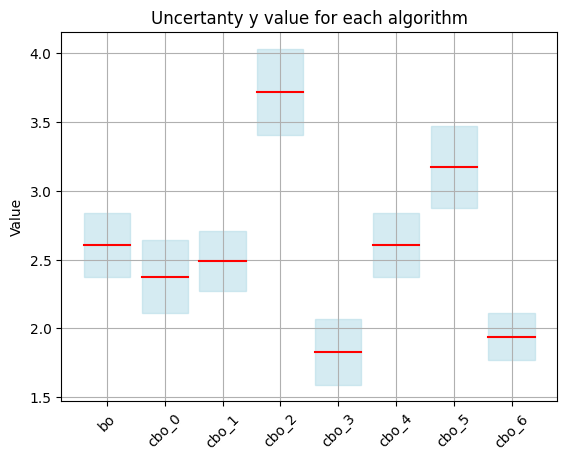

In [5]:
uncertanty_results = all_uncertainties(base_path=base_path, num_cbo_graphs=7, n_obs=200)
print(uncertanty_results)
box_plots_mean(uncertanty_results, experiment="Uncertanty")

# Graph 6

{'ceo': {'mean': 13.612690228042458, 'std': 0.28969069537523273}, 'bo': {'mean': 13.594847912363916, 'std': 0.105825581597199}, 'cbo_0': {'mean': 13.345327446416949, 'std': 0.21590074225238606}, 'cbo_1': {'mean': 13.291566659501642, 'std': 0.1332674515728911}, 'cbo_2': {'mean': 13.384226272781323, 'std': 0.2664668313984118}, 'cbo_3': {'mean': 13.305397659158958, 'std': 0.15822601160942285}, 'cbo_4': {'mean': 13.766044913512845, 'std': 0.19132970706037836}}


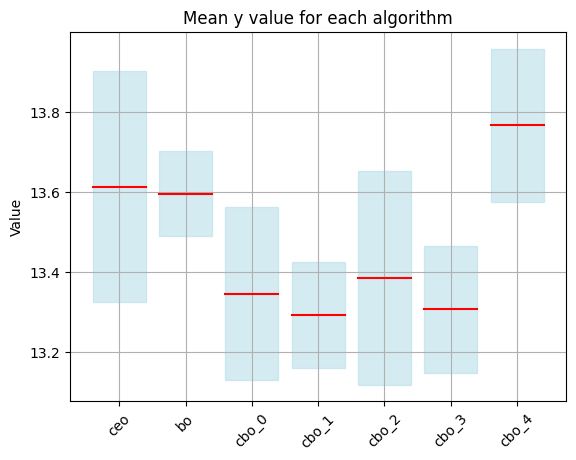

In [7]:
base_path = "Graph6"
# plot_everything(base_path=base_path, experiment="Best_Y", n_obs=10, num_cbo_graphs=7,save_file=False, plot_ceo=True, graph_idxs = [0, 4, 6])
mean_results = all_means(base_path=base_path, num_cbo_graphs=5, n_obs=200)
print(mean_results)
box_plots_mean(mean_results, experiment="Mean")

{'ceo': {'mean': 13.213725942732044, 'std': 0.061138277967993204}, 'bo': {'mean': 13.496748548285101, 'std': 0.16255758330715347}, 'cbo_0': {'mean': 13.195187060537458, 'std': 0.045799721647091896}, 'cbo_1': {'mean': 13.177693186527014, 'std': 0.051739122338015975}, 'cbo_2': {'mean': 13.214174771573871, 'std': 0.006765255366205674}, 'cbo_3': {'mean': 13.203197200674548, 'std': 0.012433998372080418}, 'cbo_4': {'mean': 13.475014606544779, 'std': 0.12596289691371362}}


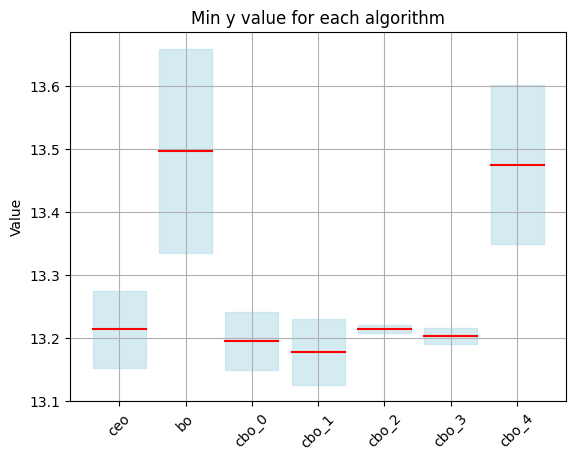

In [8]:
min_results = all_best(base_path=base_path, num_cbo_graphs=5, n_obs=200)
print(min_results)
box_plots_mean(min_results, experiment="Min")

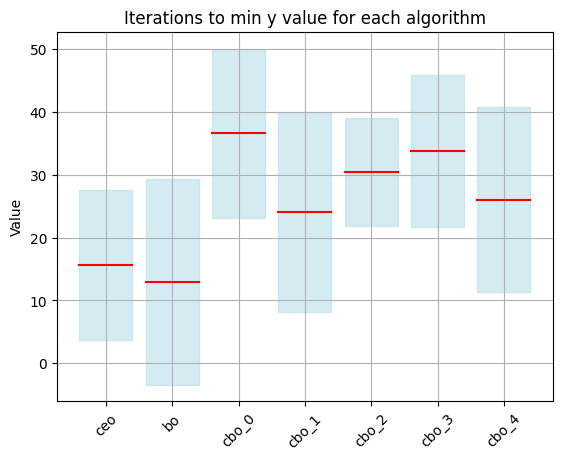

In [9]:
argmin_results = iterations_to_min(base_path=base_path, num_cbo_graphs=5)
box_plots_mean(argmin_results, experiment="Iterations to min")

{'bo': {'mean': 43.46725530470896, 'std': 8.854592476174426}, 'cbo_0': {'mean': 44.39436947969256, 'std': 8.857756635606856}, 'cbo_1': {'mean': 33.104400125574685, 'std': 7.901886867092098}, 'cbo_2': {'mean': 33.99801668429239, 'std': 9.03405736941839}, 'cbo_3': {'mean': 22.666300074802614, 'std': 7.499653246308411}, 'cbo_4': {'mean': 2.3809530110689487, 'std': 0.15534010656662958}}


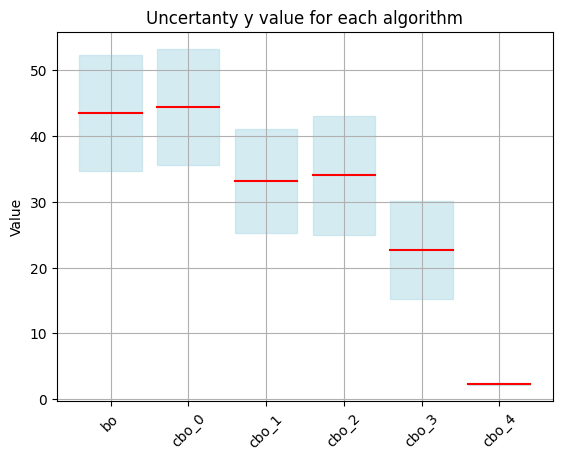

In [10]:
uncertanty_results = all_uncertainties(base_path=base_path, num_cbo_graphs=5, n_obs=200)
print(uncertanty_results)
box_plots_mean(uncertanty_results, experiment="Uncertanty")

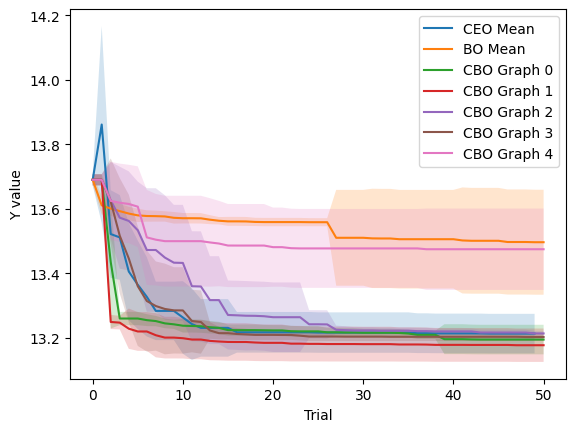

In [11]:
base_path = "Graph6"
plot_everything(base_path=base_path, experiment="Best_Y", n_obs=200, num_cbo_graphs=5)

# Investigating how the uncertainty changes as the method evolve

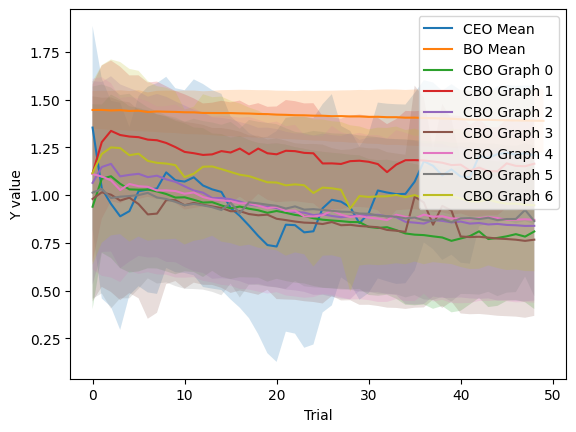

In [12]:
base_path = "ToyGraph"
plot_everything(base_path=base_path, experiment="Uncertainty", n_obs=200, num_cbo_graphs=7)

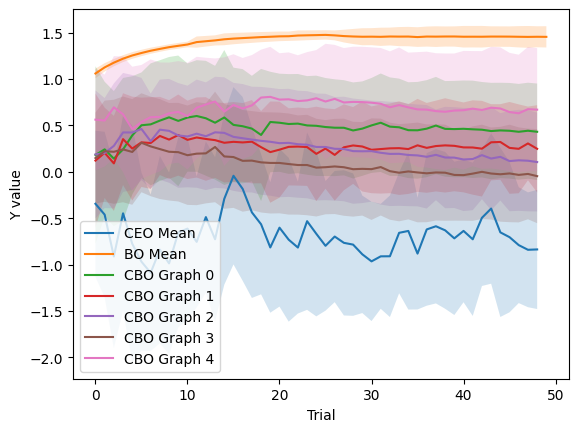

In [13]:
base_path = "Graph6"
plot_everything(base_path=base_path, experiment="Uncertainty", n_obs=200, num_cbo_graphs=5)